<a href="https://colab.research.google.com/github/mujammil-shaikh/Machine_Learning_Project/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds

import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
tfds.disable_progress_bar()

In [3]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-08-06 11:15:43--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.06s   

2023-08-06 11:15:43 (6.10 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-08-06 11:15:43--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [4]:
train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [5]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

train_df.head()

train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [7]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [8]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 36s 320ms/step - loss: 0.6791 - accuracy: 0.8657 - val_loss: 0.6579 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 6s 125ms/step - loss: 0.6162 - accuracy: 0.8657 - val_loss: 0.5611 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 6s 132ms/step - loss: 0.5111 - accuracy: 0.8657 - val_loss: 0.4835 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 4s 81ms/step - loss: 0.4472 - accuracy: 0.8657 - val_loss: 0.4049 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 3s 76ms/step - loss: 0.3532 - accuracy: 0.8657 - val_loss: 0.2769 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 4s 81ms/step - loss: 0.2109 - accuracy: 0.8721 - val_loss: 0.1530 - val_accuracy: 0.9354
Epoch 7/10
44/44 [==============================] - 2s 53ms/step - loss: 0.1239 - accuracy: 0.9641 - val_loss: 0.0933 - val_accuracy: 0.9823
Epoch 8/1

In [9]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 1s 12ms/step - loss: 0.0434 - accuracy: 0.9885
Test Loss: 0.043352194130420685
Test Accuracy: 0.9885057210922241


(0.0, 0.7107368629425764)

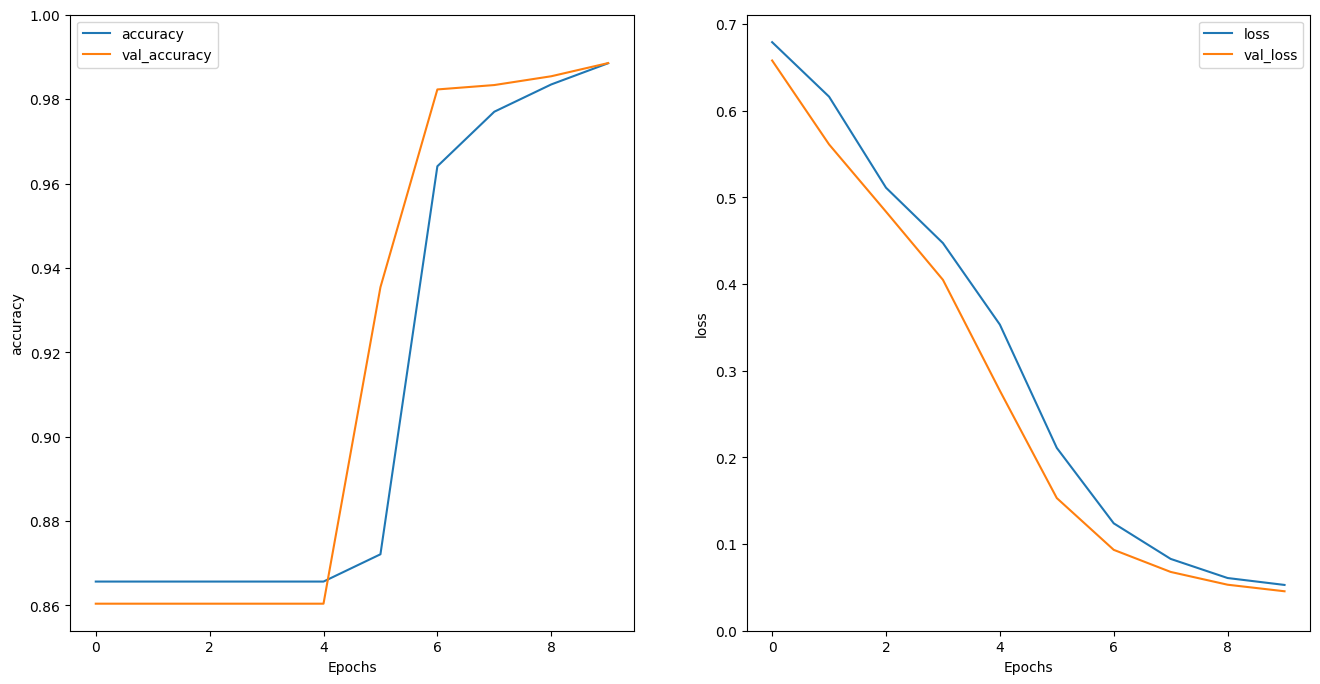

In [10]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [11]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6790596842765808, 0.616192102432251, 0.5111477971076965, 0.4472483992576599, 0.3531985580921173, 0.21093061566352844, 0.12389959394931793, 0.08286361396312714, 0.060799740254879, 0.052824344485998154]
[0.6579276919364929, 0.5611101984977722, 0.4834747016429901, 0.4048592150211334, 0.27691081166267395, 0.15303516387939453, 0.0933167114853859, 0.06783313304185867, 0.05308447778224945, 0.045516110956668854]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8721264600753784, 0.9640804529190063, 0.977011501789093, 0.983476996421814, 0.9885057210922241]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9354166388511658, 0.9822916388511658, 0.9833333492279053, 0.9854166507720947, 0.9885416626930237]


In [12]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 4s 4s/step
[[-3.7223473]]
[-3.7223473, 'ham']


In [13]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 41ms/step
[[-3.7223473]]
1/1 [==============================] - 0s 37ms/step
[[0.7118907]]
1/1 [==============================] - 0s 38ms/step
[[-9.491438]]
1/1 [==============================] - 0s 39ms/step
[[1.4224505]]
1/1 [==============================] - 0s 43ms/step
[[2.1153746]]
1/1 [==============================] - 0s 40ms/step
[[-7.9029818]]
1/1 [==============================] - 0s 40ms/step
[[-7.996463]]
You passed the challenge. Great job!
